# Bayesian Portfolio Optimization using MCMC
**Authors**
- Jingyi Fan, jf4258@nyu.edu, N15191508
- Tianyu Li, tl3472@nyu.edu, N18586573
- Wenxin Zhang, wz2127@nyu.edu, N15067695


# Introduction

In this project, we assess the following questions:
- How to estimate the return on a stock market investment?
- How to find the optimal asset allocation with the selected stocks?

We use the Fama-French Three-Factors Model as our theoretical model and aim to predict the returns of 30 stocks with the highest market capitalization in the technology industry. We then conduct the Bayesian regression using the baseline model and 2 hierarchical models to estimate the parameters. Based on the previous estimation, we further select 3 stocks with the highest predicted returns and conduct portfolio optimization using Monte Carlo Simulation.

# Outline

This report is structured in the following manner:

**1. Data**
- 1.1. Data Preparation
- 1.2. Data Description

**2. Theoretical Model and Stock Return Prediction**
- 2.1. Fama-French Three-Factors Model
- 2.2. Baseline Model
- 2.3. Hierarchical Model
- 2.4. Return Prediction

**3. Portfolio Optimization**
- 3.1. Stock Selection
- 3.2. Monte Carlo Simulation
- 3.3. The Optimal Portfolio

### Import Packages

In [47]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as gff

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns

%matplotlib inline
sns.set()

# 1. Data

## 1.1. Data Preparation
The stock dataset used in this notebook comes from [Yahoo Finance](https://finance.yahoo.com/) from `2000-01-01` to `2022-11-30`.
In this project, we mainly focus on the top 30 market capitalization technology companies.

In [48]:
tickers = [
    'aapl', 'msft', 'nvda', 'tsm' , 'asml',
    'cdns', 'orcl', 'csco', 'aph' , 'txn' ,
    'adbe', 'qcom', 'ibm' , 'msi' , 'sap' ,
    'intc', 'intu', 'amd' , 'sony', 'amat',
    'adi' , 'nov' , 'infy', 'fisv', 'lrcx',
    'mu'  , 'klac', 'mchp', 'adsk', 'snps'
]
start = '2000-01-01'
end = '2022-12-01'

stock_data = yf.download(
    tickers=tickers,
    start=start, end=end
)

[*********************100%***********************]  30 of 30 completed


For each stock, we obtain the following data:

- High: daily highest stock price
- Low: daily highest close price
- Open: daily open price
- Close: daily close price
- Volume: daily number of traded stock shares
- Adj Close: daily adjusted close price

We use the `Adjusted Close Price` for further analysis.

In [49]:
stock_data.head()

Adj Close                                                     \
                AAPL       ADBE        ADI      ADSK       AMAT     AMD   
Date                                                                      
2000-01-03  0.851942  16.274670  29.116411  8.052905  23.534830  15.500   
2000-01-04  0.780115  14.909400  27.643436  7.660817  22.372038  14.625   
2000-01-05  0.791530  15.204172  28.046995  7.178245  21.534832  15.000   
2000-01-06  0.723033  15.328292  27.280235  6.740915  21.569715  16.000   
2000-01-07  0.757282  16.072979  28.046995  7.540175  21.755758  16.250   

                                                     ...   Volume          \
                 APH       ASML     CDNS       CSCO  ...       MU     NOV   
Date                                                 ...                    
2000-01-03  1.879147  27.357792  22.0625  38.369209  ...  6564600  200951   
2000-01-04  1.814528  25.535902  22.0000  36.216618  ...  7220800  365305   
2000-01-05  1.774361  24.830652  21.6250  36.105659  ...  6763800  229341   
2000-01-06  1.725461  23.302610  20.9375  35.506500  ...  6338400  419424   
2000-01-07  1.742925  23.831547  22.3125  37.592495  ...  9467200  887865   

                                                                        \
                  NVDA       ORCL      QCOM      SAP     SNPS     SONY   
Date                                                                     
2000-01-03  30091200.0   98114800  91334000   665800  2315600  2587000   
2000-01-04  30048000.0  116824800  63567400  2358800  1291000  3019600   
2000-01-05  18835200.0  166054000  93778400  1433100  3343800  3086800   
2000-01-06  12048000.0  109880000  58782600   957100  3107400  3922600   
2000-01-07   7118400.0   91755600  68198600  4356100  1710800  2244000   

                               
                TSM       TXN  
Date                           
2000-01-03  2062807  10815600  
2000-01-04  2557142   7952400  
2000-01-05  2295467  12142400  
2000-01-06  1539456  11758400  
2000-01-07  1511230  12938800  

[5 rows x 180 columns]

In [50]:
stock_data.shape

(5766, 180)

Text(0, 0.5, 'Daily Adjusted Close Price')

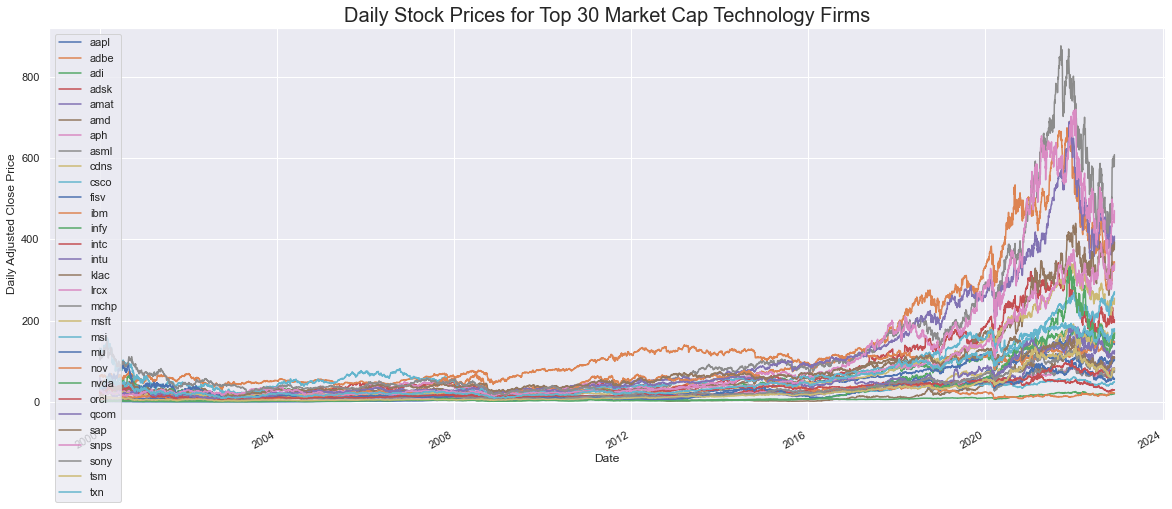

In [51]:
tickers.sort()
stock_data['Adj Close'].plot(legend=True, figsize=(20, 8))
plt.legend(tickers, loc='upper left')
plt.title("Daily Stock Prices for Top 30 Market Cap Technology Firms", size=20)
plt.ylabel("Daily Adjusted Close Price")

Because available market data is in monthly manners, we here take percentage change of daily stock prices in order to convert into monthly returns. The dataset contains a total of `274 months` after conversion.

In [52]:
stock_returns = stock_data['Adj Close'].resample('M').last().pct_change()[1:]
stock_returns.head()

,AAPL,ADBE,ADI,ADSK,AMAT,AMD,APH,ASML,CDNS,CSCO,...,MU,NOV,NVDA,ORCL,QCOM,SAP,SNPS,SONY,TSM,TXN
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-29,0.104820,0.852440,0.681818,0.462168,0.332878,0.097222,0.177717,0.042196,-0.033333,0.207192,...,0.543719,0.293333,0.726812,0.486395,0.121555,0.093960,-0.135318,0.239130,0.153012,0.541764
2000-03-31,0.184842,0.091567,0.023847,0.018181,0.030407,0.493671,0.279124,-0.127805,0.034483,0.169740,...,0.312500,0.273196,0.320069,0.051346,0.048267,-0.162138,0.220657,-0.105620,-0.047022,-0.036870
2000-04-30,-0.086517,0.086468,-0.045808,-0.155447,0.080239,0.483051,0.246943,0.073826,-0.184848,-0.103274,...,0.105655,-0.224696,0.054929,0.024019,-0.273755,-0.177824,-0.138462,-0.194556,-0.082237,0.018262
2000-05-31,-0.322922,-0.069251,0.002441,-0.030945,-0.179865,-0.065714,-0.282353,-0.110938,-0.048327,-0.178725,...,0.004038,0.086162,0.280504,-0.100860,-0.387896,-0.125004,0.126488,-0.191690,-0.135962,-0.112817
2000-06-30,0.247024,0.155146,-0.012987,-0.067227,0.085329,-0.055046,0.444671,0.240773,0.273438,0.116356,...,0.259160,0.265024,0.113911,0.169565,-0.096045,0.087464,-0.269485,0.034270,0.092036,-0.049308


In [53]:
stock_returns.shape

(274, 30)

For market data, we use `getFamaFrenchFactors` package for monthly market return, the size premium (SMB), the value premium (HML), and the risk free return (RF) for further analysis.

In [54]:
ff3_monthly = gff.famaFrench3Factor(frequency='m')
ff3_monthly.rename(columns={"date_ff_factors": 'Date',"Mkt-RF": "Mkt_RF"}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)
ff3_monthly.tail()

,Mkt_RF,SMB,HML,RF
Date,,,,
2022-06-30,-0.0843,0.0209,-0.0597,0.0006
2022-07-31,0.0957,0.0281,-0.0410,0.0008
2022-08-31,-0.0377,0.0139,0.0031,0.0019
2022-09-30,-0.0935,-0.0082,0.0003,0.0019
2022-10-31,0.0783,0.0010,0.0806,0.0023


Text(0.5, 0, 'Year')

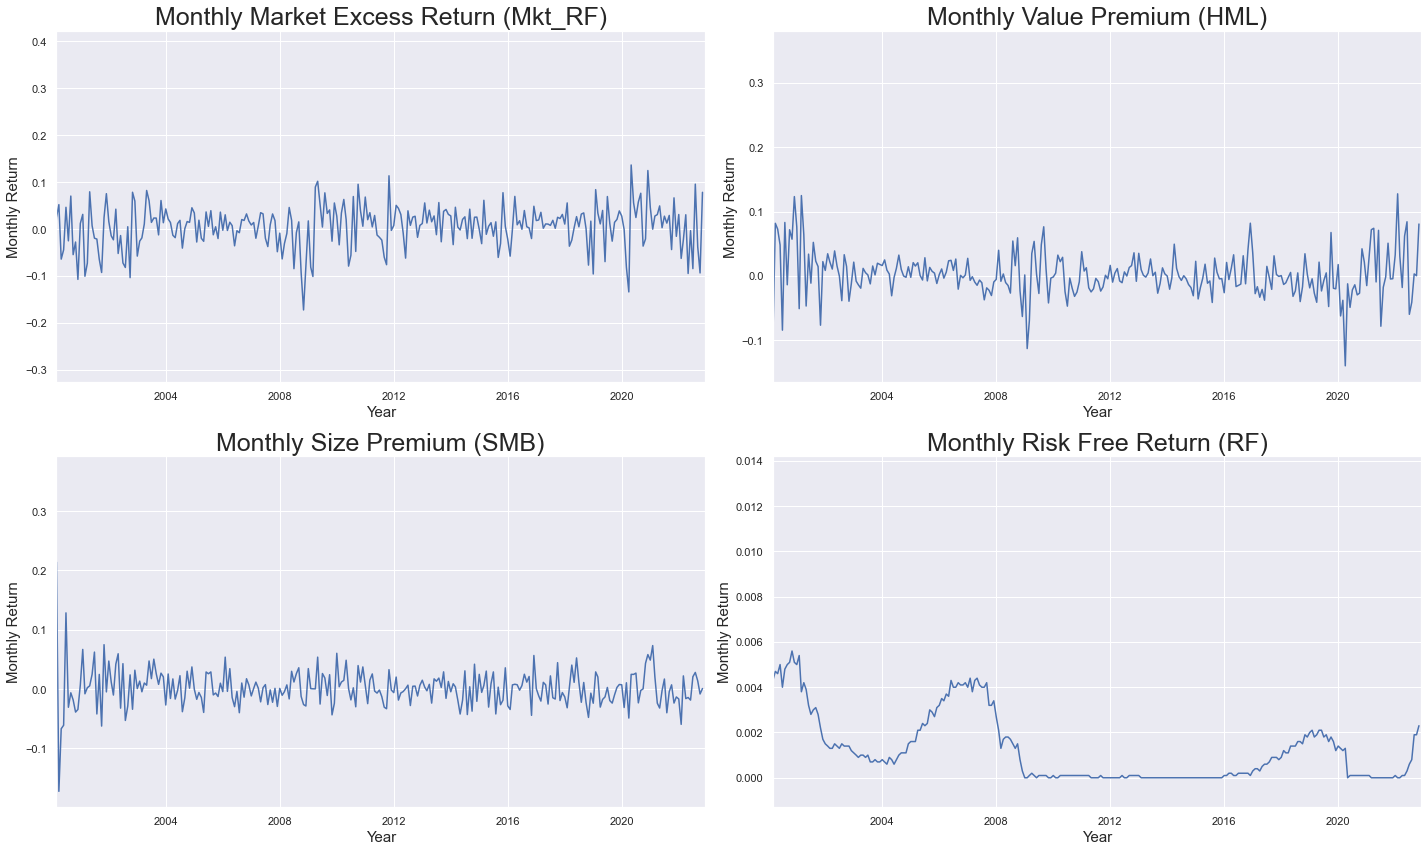

In [55]:
fig, axs = plt.subplots(2, 2, sharey=False, tight_layout=True,figsize=(20, 12))

axs[0][0].plot(ff3_monthly['Mkt_RF'])
axs[0][0].set_title("Monthly Market Excess Return (Mkt_RF)", size=25)
axs[0][0].set_xlim(min(stock_returns.index.to_list()), max(stock_returns.index.to_list()))
axs[0][0].set_ylabel("Monthly Return", size=15)
axs[0][0].set_xlabel("Year", size=15)

axs[1][0].plot(ff3_monthly['SMB'])
axs[1][0].set_title("Monthly Size Premium (SMB)", size=25)
axs[1][0].set_xlim(min(stock_returns.index.to_list()), max(stock_returns.index.to_list()))
axs[1][0].set_ylabel("Monthly Return", size=15)
axs[1][0].set_xlabel("Year", size=15)

axs[0][1].plot(ff3_monthly['HML'])
axs[0][1].set_title("Monthly Value Premium (HML)", size=25)
axs[0][1].set_xlim(min(stock_returns.index.to_list()), max(stock_returns.index.to_list()))
axs[0][1].set_ylabel("Monthly Return", size=15)
axs[0][1].set_xlabel("Year", size=15)

axs[1][1].plot(ff3_monthly['RF'])
axs[1][1].set_title("Monthly Risk Free Return (RF)", size=25)
axs[1][1].set_xlim(min(stock_returns.index.to_list()), max(stock_returns.index.to_list()))
axs[1][1].set_ylabel("Monthly Return", size=15)
axs[1][1].set_xlabel("Year", size=15)

Then we combine the two dataframes by merging on the date to finish up data preparation.

In [56]:
ff_data = ff3_monthly.merge(stock_returns,on='Date')
print(ff_data.shape)
ff_data.head()

(273, 34)


,Mkt_RF,SMB,HML,RF,AAPL,ADBE,ADI,ADSK,AMAT,AMD,...,MU,NOV,NVDA,ORCL,QCOM,SAP,SNPS,SONY,TSM,TXN
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-29,0.0245,0.2142,-0.0970,0.0043,0.104820,0.852440,0.681818,0.462168,0.332878,0.097222,...,0.543719,0.293333,0.726812,0.486395,0.121555,0.093960,-0.135318,0.239130,0.153012,0.541764
2000-03-31,0.0520,-0.1723,0.0817,0.0047,0.184842,0.091567,0.023847,0.018181,0.030407,0.493671,...,0.312500,0.273196,0.320069,0.051346,0.048267,-0.162138,0.220657,-0.105620,-0.047022,-0.036870
2000-04-30,-0.0640,-0.0668,0.0726,0.0046,-0.086517,0.086468,-0.045808,-0.155447,0.080239,0.483051,...,0.105655,-0.224696,0.054929,0.024019,-0.273755,-0.177824,-0.138462,-0.194556,-0.082237,0.018262
2000-05-31,-0.0442,-0.0609,0.0481,0.0050,-0.322922,-0.069251,0.002441,-0.030945,-0.179865,-0.065714,...,0.004038,0.086162,0.280504,-0.100860,-0.387896,-0.125004,0.126488,-0.191690,-0.135962,-0.112817
2000-06-30,0.0464,0.1285,-0.0843,0.0040,0.247024,0.155146,-0.012987,-0.067227,0.085329,-0.055046,...,0.259160,0.265024,0.113911,0.169565,-0.096045,0.087464,-0.269485,0.034270,0.092036,-0.049308


Check NA value. Gladly we have 0 :)

In [57]:
ff_data.isna().sum()
a = pd.DataFrame({"NA":ff_data.isna().sum()})
a[a["NA"] != 0]

,NA


## 1.2. Data Description

In [58]:
ff_data.describe()

,Mkt_RF,SMB,HML,RF,AAPL,ADBE,ADI,ADSK,AMAT,AMD,...,MU,NOV,NVDA,ORCL,QCOM,SAP,SNPS,SONY,TSM,TXN
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,...,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,0.005318,0.001878,0.002533,0.001216,0.026404,0.017640,0.011262,0.019724,0.010427,0.021849,...,0.013088,0.012105,0.033873,0.009179,0.009141,0.008266,0.013217,0.003121,0.011806,0.010018
std,0.046270,0.032013,0.034958,0.001467,0.114045,0.112645,0.107808,0.121164,0.108846,0.190271,...,0.146372,0.124447,0.174574,0.093032,0.103838,0.107919,0.087710,0.102341,0.101681,0.095756
min,-0.172300,-0.172300,-0.139700,0.000000,-0.577437,-0.334764,-0.404154,-0.375536,-0.339986,-0.410489,...,-0.499335,-0.472094,-0.486551,-0.347640,-0.387896,-0.415585,-0.367921,-0.295759,-0.416071,-0.325343
25%,-0.019700,-0.017400,-0.016600,0.000000,-0.039522,-0.044722,-0.049308,-0.055829,-0.057221,-0.088710,...,-0.072838,-0.064328,-0.056047,-0.047405,-0.047502,-0.041870,-0.031041,-0.062986,-0.043258,-0.041340
50%,0.011700,0.001200,-0.000200,0.000700,0.033789,0.027741,0.009846,0.019281,0.005400,0.002634,...,0.006944,0.008915,0.027731,0.012944,0.012980,0.006637,0.012090,0.007134,0.018361,0.013065
75%,0.032300,0.018700,0.019700,0.001800,0.098097,0.076482,0.059533,0.097580,0.077004,0.137358,...,0.105655,0.085017,0.119157,0.057429,0.066073,0.053918,0.062563,0.071507,0.065245,0.065566
max,0.136500,0.214200,0.127500,0.005600,0.453782,0.852440,0.681818,0.462168,0.396669,0.780996,...,0.543719,0.459524,0.826237,0.486395,0.510258,0.701333,0.373316,0.333929,0.399420,0.541764


Text(0.5, 0, 'Stock Ticker')

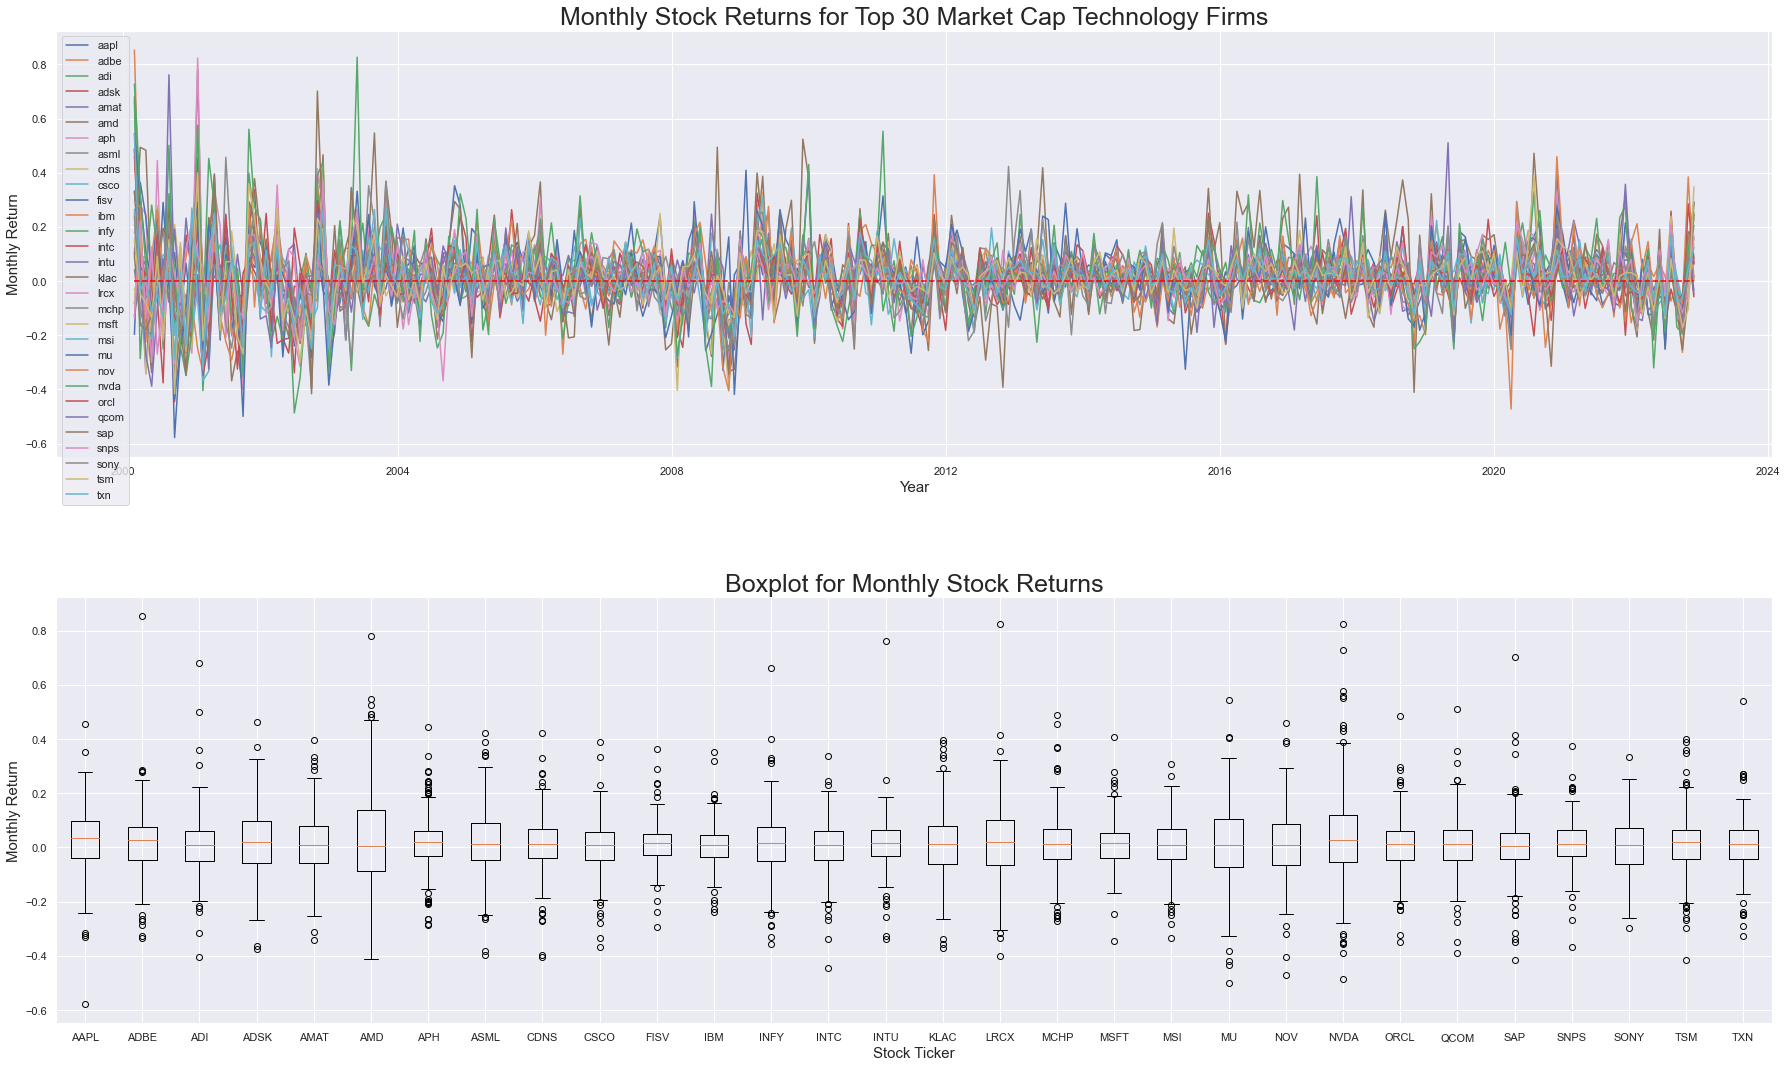

In [59]:
fig, axs = plt.subplots(2, 1, sharey=False, tight_layout=True,figsize=(25, 15))

axs[0].plot(stock_returns)
axs[0].legend(tickers, loc='upper left')
axs[0].set_title("Monthly Stock Returns for Top 30 Market Cap Technology Firms", size=25)
axs[0].hlines(y=0, xmin=min(stock_returns.index.to_list()), xmax=max(stock_returns.index.to_list()), color='red', linestyle='--')
axs[0].set_ylabel("Monthly Return", size=15)
axs[0].set_xlabel("Year", size=15)

axs[1].boxplot(stock_returns, labels=stock_returns.columns.to_list())
axs[1].set_title("Boxplot for Monthly Stock Returns", size=25)
axs[1].set_ylabel("Monthly Return", size=15)
axs[1].set_xlabel("Stock Ticker", size=15)

# 2. Theoretical Model and Stock Return Prediction

For the second part of the project, we choose `Fama-French Three-Factors` model as our theoretical model, and run Baysian hierarchical regression to estimate model parameters. We then plug the estimated parameters back into the theoretical model to calculate each firm's stock returns for the next period. In the third part of the project, we will use the estimated returns as the input to estimate portfolio return.

## 2.1. Fama-French Three-Factors Model

The reason we chose Fama-French Three-Factors Model is that it empirically explains over 90% of excess returns. The Fama-French model is described by the following equation:

$$ R_{it} - R_{ft} = \alpha_{it} + \beta_{1i}(R_{mt}-R_{ft}) + \beta_{2i} \text{SMB}_t + \beta_{3i} \text{HML}_t + \sigma\epsilon_{it}$$

There are a few components to this equation:

* $R_{it}$: The monthly return of a particular asset
* $R_{ft}$: The risk-free return <-- This is `RF` in the dataset
* $R_{mt}$: The market return <-- The term ($R_{m, t} - R_{f, t}$) corresponds to `Mkt_RF` in the dataset
* $\text{SMB}_t$: The Small Minus Big term is the size premium, which is the average monthly return on the smallest 30% of stocks minus the average monthly return on the largest 30%.
* $\text{HML}_t$: The Hight Minus Low term is the value premium, which is the average monthly return for the 50% of stocks with the highest book-to-market ratio minus the average return for the 50% of stocks with the lowest book-to-market ratio.

Given the available stock and market data, we use `pymc3` package to estimate the model parameters（i.e. $\alpha_i$, $\beta_{1i}$, $\beta_{2i}$, $\beta_{3i}$) of the Fama-French model for 30 tech firms.

## 2.2. Baseline Model
First, we develop a baseline model to conduct the regression. We are interested in whether different stocks actually have different relationships (slope), i.e., estimating 30 different regressions one for each stock.

Our baseline model will be described by: 

\begin{align*}
   r_{i, t} - r_{f, t} &= \alpha_{it} + \beta_{1i} (r_{m, t} - r_{f, t}) +  \beta_{2i} \text{SMB}_t + \beta_{3i} \text{HML}_t + \sigma_i \varepsilon_{i, t}\\

   \alpha_i &\sim N(0, 2) \\
   \beta_{1i} &\sim N(0, 5) \\
   \beta_{2i} &\sim N(0, 5) \\
   \beta_{3i} &\sim N(0, 5) \\
   \sigma_i &\sim \text{HalfStudentT}(5)
\end{align*}

We now build the model in PyMC3, specifying the stock-specific parameters and the likelihood function.

In [60]:
# Basic data for baseline model

ri_m_rf = []
rm_m_rf = []
SMB = []
HML = []

tickers = ff_data.columns[4:].to_list()

ntickers = len(tickers)
ticker_2_int = dict(zip(tickers, range(ntickers)))

ticker_idx = []
for ticker in tickers:
  ri_m_rf.extend(ff_data[ticker] - ff_data['RF'])
  rm_m_rf.extend(ff_data['Mkt_RF'] - ff_data['RF'])
  SMB.extend(ff_data['SMB'])
  HML.extend(ff_data['HML'])
  for i in range(ff_data.shape[0]):
    ticker_idx.append(ticker_2_int[ticker])

In [61]:
# baseline model specification

m_baseline = pm.Model()

with m_baseline:
    # Data
    _ri_m_rf = pm.Data("ri_m_rf", ri_m_rf)
    _rm_m_rf = pm.Data("rm_m_rf", rm_m_rf)
    _SMB = pm.Data("SMB", SMB)
    _HML = pm.Data("HML", HML)
    _ticker_idx = pm.intX(pm.Data("ticker_idx", ticker_idx))                    

    # Prior
    alpha_it = pm.Normal("alpha_i", 0.0, 2.0, shape=ntickers) 
    beta_1_i = pm.Normal("beta_1_i", 0.0, 5.0, shape=ntickers)
    beta_2_i = pm.Normal("beta_2_i", 0.0, 5.0, shape=ntickers)
    beta_3_i = pm.Normal("beta_3_i", 0.0, 5.0, shape=ntickers)                      
    sigma_i = pm.HalfStudentT("sigma_i", 5.0, shape=ntickers)

    # Likelihood
    obs_it_RF = pm.Normal("obs_it_RF", alpha_it[_ticker_idx] + beta_1_i[_ticker_idx]*_rm_m_rf + \
    beta_2_i[_ticker_idx]*_SMB + beta_3_i[_ticker_idx]*_HML, sigma_i[_ticker_idx], observed=_ri_m_rf)

In [62]:
# m_baseline.check_test_point()
with m_baseline:
    traces_baseline = pm.sample(2500, tune=1000)

/Users/clairefan/.local/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_i, beta_3_i, beta_2_i, beta_1_i, alpha_i]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 104 seconds.


Below are the distributions of the parameters for each stock that we estimated using the baseline model.

In [63]:
betas_baseline = pd.DataFrame(
    {
        "alpha_i_mean": traces_baseline["alpha_i"].mean(axis=0),
        "alpha_i_std": traces_baseline["alpha_i"].std(axis=0),
        "beta_1_mean": traces_baseline["beta_1_i"].mean(axis=0),
        "beta_1_std": traces_baseline["beta_1_i"].std(axis=0),
        "beta_2_mean": traces_baseline["beta_2_i"].mean(axis=0),
        "beta_2_std": traces_baseline["beta_2_i"].std(axis=0),
        "beta_3_mean": traces_baseline["beta_3_i"].mean(axis=0),
        "beta_3_std": traces_baseline["beta_3_i"].std(axis=0),
        "sigma_mean": traces_baseline["sigma_i"].mean(axis=0),
        "sigma_std": traces_baseline["sigma_i"].std(axis=0)
    }, index=tickers
)

betas_baseline.T

,AAPL,ADBE,ADI,ADSK,AMAT,AMD,APH,ASML,CDNS,CSCO,...,MU,NOV,NVDA,ORCL,QCOM,SAP,SNPS,SONY,TSM,TXN
alpha_i_mean,0.021545,0.011196,0.004194,0.011346,0.001891,0.011864,0.012144,0.009415,0.006578,-0.000599,...,0.004794,0.002426,0.025962,0.004160,0.003805,0.002276,0.008546,-0.003515,0.005885,0.003577
alpha_i_std,0.005492,0.005481,0.004680,0.005723,0.004563,0.009643,0.004334,0.005200,0.004734,0.004423,...,0.007570,0.006131,0.008957,0.004543,0.005497,0.004970,0.004509,0.005240,0.004745,0.004416
beta_1_mean,1.328662,1.302240,1.341456,1.514885,1.467232,2.287820,1.368664,1.676620,1.361470,1.343996,...,1.451932,1.350040,1.823282,1.113329,1.131129,1.492436,1.089742,1.154896,1.284969,1.219815
beta_1_std,0.124021,0.118926,0.106375,0.126158,0.102411,0.211438,0.093111,0.117946,0.103846,0.098177,...,0.166190,0.140151,0.195635,0.100269,0.124783,0.111945,0.099062,0.113183,0.104220,0.097396
beta_2_mean,0.080946,0.566921,0.731654,0.582131,0.801551,0.131007,0.092807,0.379651,0.118448,0.074105,...,0.794019,0.641594,0.637709,0.238898,-0.050636,-0.017335,-0.311117,0.441086,0.328287,0.442444
beta_2_std,0.184757,0.173611,0.156236,0.188381,0.148839,0.315556,0.141137,0.172300,0.154033,0.145146,...,0.246435,0.205475,0.291741,0.147930,0.185003,0.162905,0.149078,0.171753,0.158871,0.145976
beta_3_mean,-0.785244,-0.442927,-0.384094,-0.033356,-0.080836,-0.317953,-0.403459,-0.360317,-0.373976,-0.365390,...,-0.139621,0.680189,-0.795832,-0.488715,-0.152361,-0.512667,-0.179824,-0.077109,-0.470449,-0.249011
beta_3_std,0.159830,0.155479,0.137905,0.166393,0.130938,0.278034,0.124247,0.149140,0.136076,0.128236,...,0.218236,0.181844,0.256674,0.127774,0.161171,0.145869,0.129198,0.149501,0.140632,0.129575
sigma_mean,0.091697,0.088539,0.078487,0.093801,0.075299,0.157820,0.069750,0.084841,0.077782,0.071875,...,0.124576,0.101428,0.145504,0.073631,0.090595,0.081336,0.073446,0.084245,0.077882,0.072703
sigma_std,0.003994,0.003794,0.003379,0.004056,0.003288,0.006761,0.003044,0.003716,0.003430,0.003048,...,0.005444,0.004449,0.006359,0.003159,0.003999,0.003587,0.003208,0.003705,0.003381,0.003089


Next, instead of creating 30 models separately, we use the hierarchical model to generate group parameters that consider the 30 stocks not as completely different but as having an underlying similarity, which subsequently influence the distribution of each stock's $\beta_{1}$, $\beta_{2}$, and $\beta_{3}$ of the Fama-French model.

## 2.3. Hierarchical Model

A hierarchical version of the Fama-French Model can be specified as:

\begin{align*}
   r_{i, t} - r_{f, t} &= \alpha_{it} + \beta_{1i} (r_{m, t} - r_{f, t}) +  \beta_{2i} \text{SMB}_t + \beta_{3i} \text{HML}_t + \sigma_i \varepsilon_{i, t}\\
   
   \alpha_i &\sim N(0, 2) \\
   \beta_{1i} &\sim N(\hat{\mu_1}_i, \hat{\sigma_1}_i) \\
   \beta_{2i} &\sim N(\hat{\mu_2}_i, \hat{\sigma_2}_i) \\
   \beta_{3i} &\sim N(\hat{\mu_3}_i, \hat{\sigma_3}_i) \\
   \sigma_i &\sim \text{HalfStudentT}(5) \\
   \hat{\mu}_j &\sim N(0, 5) ,    j=1,2,3\\
   \hat{\sigma}_j &\sim \text{HalfStudentT}(5),     j=1,2,3

\end{align*}


In [64]:
company_idx = list(ticker_2_int.values())

In [65]:
m_hierarchical_1 = pm.Model()

with m_hierarchical_1:
    # Data
    _ri_m_rf = pm.Data("ri_m_rf", ri_m_rf)
    _rm_m_rf = pm.Data("rm_m_rf", rm_m_rf)
    _SMB = pm.Data("SMB", SMB)
    _HML = pm.Data("HML", HML)
    _ticker_idx = pm.intX(pm.Data("ticker_idx", ticker_idx))
    _company_idx = pm.intX(pm.Data("company_idx", company_idx))

    # Hyperprior
    muhat_1    = pm.Normal("mu_hat_1_1", 0, 5, shape=ntickers)
    sigmahat_1 = pm.HalfStudentT("sigma_hat_1_1", 5, shape=ntickers)
    muhat_2    = pm.Normal("mu_hat_2_1", 0, 5, shape=ntickers)
    sigmahat_2 = pm.HalfStudentT("sigma_hat_2_1", 5, shape=ntickers)
    muhat_3    = pm.Normal("mu_hat_3_1", 0, 5, shape=ntickers)
    sigmahat_3 = pm.HalfStudentT("sigma_hat_3_1", 5, shape=ntickers)
    
    # Prior
    alpha_it = pm.Normal("alpha_it_1", 0.0, 2.0, shape=ntickers)
    beta_1_i = pm.Normal(
        "beta_1_i_1", muhat_1[_company_idx], sigmahat_1[_company_idx],
        shape=ntickers
    )
    beta_2_i = pm.Normal(
        "beta_2_i_1", muhat_2[_company_idx], sigmahat_2[_company_idx],
        shape=ntickers
    )
    beta_3_i = pm.Normal(
        "beta_3_i_1", muhat_3[_company_idx], sigmahat_3[_company_idx],
        shape=ntickers
    )
    sigma_i = pm.HalfStudentT("sigma_i_1", 5.0, shape=ntickers)

    # Likelihood
    obs_it_RF = pm.Normal("obs_it_RF", alpha_it[_ticker_idx] + beta_1_i[_ticker_idx]*_rm_m_rf + beta_2_i[_ticker_idx]*_SMB + beta_3_i[_ticker_idx]*_HML, sigma_i[_ticker_idx], observed=_ri_m_rf)

In [66]:
with m_hierarchical_1:
    traces_hierarchical_1 = pm.sample(2000, tune=1500)

/Users/clairefan/.local/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_i_1, beta_3_i_1, beta_2_i_1, beta_1_i_1, alpha_it_1, sigma_hat_3_1, mu_hat_3_1, sigma_hat_2_1, mu_hat_2_1, sigma_hat_1_1, mu_hat_1_1]


Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 573 seconds.
There were 1467 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6104877900823282, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1799 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2723889175876916, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1870 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.19648146052939341, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1139 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The e

Below are the distributions of the parameters for each stock that we estimated using the hierarchical model.

In [67]:
betas_hierarchical_1 = pd.DataFrame(
    {
        "alpha_it_mean": traces_hierarchical_1["alpha_it_1"].mean(axis=0),
        "alpha_it_std": traces_hierarchical_1["alpha_it_1"].std(axis=0),
        "beta_1_mean": traces_hierarchical_1["beta_1_i_1"].mean(axis=0),
        "beta_1_std": traces_hierarchical_1["beta_1_i_1"].std(axis=0),
        "beta_2_mean": traces_hierarchical_1["beta_2_i_1"].mean(axis=0),
        "beta_2_std": traces_hierarchical_1["beta_2_i_1"].std(axis=0),
        "beta_3_mean": traces_hierarchical_1["beta_3_i_1"].mean(axis=0),
        "beta_3_std": traces_hierarchical_1["beta_3_i_1"].std(axis=0),
        "sigma_mean": traces_hierarchical_1["sigma_i_1"].mean(axis=0),
        "sigma_std": traces_hierarchical_1["sigma_i_1"].std(axis=0)
    }, index=tickers
)

betas_hierarchical_1.head().T

,AAPL,ADBE,ADI,ADSK,AMAT
alpha_it_mean,0.020007,0.012235,0.003574,0.012410,0.002928
alpha_it_std,0.005647,0.005088,0.003982,0.007057,0.004572
beta_1_mean,1.320674,1.250267,1.310744,1.498899,1.496974
beta_1_std,0.136055,0.137954,0.095626,0.135616,0.095855
beta_2_mean,0.180305,0.555986,0.816996,0.546052,0.823355
beta_2_std,0.198895,0.140476,0.185925,0.222495,0.134311
beta_3_mean,-0.763206,-0.480872,-0.346127,-0.077828,-0.033820
beta_3_std,0.125432,0.162764,0.134911,0.146583,0.137677
sigma_mean,0.090617,0.088282,0.077913,0.094646,0.074242
sigma_std,0.004210,0.003491,0.003122,0.003510,0.003733


### Diagnostics Check

Compute the estimates of the effective sample size (ess) and rank normalized R-hat (rhat) for the traces.

In [68]:
with m_hierarchical_1:
    ess = az.stats.diagnostics.ess(traces_hierarchical_1, relative=True)
    rhat = az.stats.diagnostics.rhat(traces_hierarchical_1)

In [69]:
for _var in ["beta_1_i_1", "beta_2_i_1", "beta_3_i_1", "alpha_it_1", "sigma_i_1", "mu_hat_1_1", \
    "mu_hat_2_1", "mu_hat_3_1", "sigma_hat_1_1", "sigma_hat_2_1", "sigma_hat_3_1"]:
    print(f"Variable: {_var}")
    print("\tMinimum relative ESS: ", ess[_var].min().values)
    print("\tMaximum rhat: ", rhat[_var].max().values)

Variable: beta_1_i_1
	Minimum relative ESS:  0.0010473873915179078
	Maximum rhat:  1.47639160701391
Variable: beta_2_i_1
	Minimum relative ESS:  0.0010631794424357955
	Maximum rhat:  1.3954637574062612
Variable: beta_3_i_1
	Minimum relative ESS:  0.0009528803605640021
	Maximum rhat:  1.4699601613496798
Variable: alpha_it_1
	Minimum relative ESS:  0.0008849515334632426
	Maximum rhat:  1.5556802365697115
Variable: sigma_i_1
	Minimum relative ESS:  0.0010006798621942847
	Maximum rhat:  1.4356582360157004
Variable: mu_hat_1_1
	Minimum relative ESS:  0.000962816875747967
	Maximum rhat:  1.4684498479030001
Variable: mu_hat_2_1
	Minimum relative ESS:  0.0010216600007504088
	Maximum rhat:  1.427467059084017
Variable: mu_hat_3_1
	Minimum relative ESS:  0.0009115206482697076
	Maximum rhat:  1.5185890439378433
Variable: sigma_hat_1_1
	Minimum relative ESS:  0.0011527802327342485
	Maximum rhat:  1.3682255807021926
Variable: sigma_hat_2_1
	Minimum relative ESS:  0.0010486759027007692
	Maximum rhat:

Since the relative ESS is extremely small and the rhat is much higher than 1, we assume that the between-chain and within-chain variances are not identical. Therefore, we develope `Hierarchical Model 2` to group all stocks together for estimation.

In [70]:
company_idx_2 = np.linspace(0.0, 0.0, num=ntickers)

In [71]:
## Portfolio Hierarchical Model 2

m_hierarchical_2 = pm.Model()

with m_hierarchical_2:
    # Data
    _ri_m_rf = pm.Data("ri_m_rf", ri_m_rf)
    _rm_m_rf = pm.Data("rm_m_rf", rm_m_rf)
    _SMB = pm.Data("SMB", SMB)
    _HML = pm.Data("HML", HML)
    _ticker_idx = pm.intX(pm.Data("ticker_idx", ticker_idx))
    _company_idx = pm.intX(pm.Data("company_idx", company_idx_2))

    # Hyperprior
    muhat_1    = pm.Normal("mu_hat_1_2", 0, 5, shape=1)
    sigmahat_1 = pm.HalfStudentT("sigma_hat_1_2", 5, shape=1)
    muhat_2    = pm.Normal("mu_hat_2_2", 0, 5, shape=1)
    sigmahat_2 = pm.HalfStudentT("sigma_hat_2_2", 5, shape=1)
    muhat_3    = pm.Normal("mu_hat_3_2", 0, 5, shape=1)
    sigmahat_3 = pm.HalfStudentT("sigma_hat_3_2", 5, shape=1)
    
    # Prior
    alpha_it = pm.Normal("alpha_it_2", 0.0, 1.0, shape=ntickers)
    beta_1_i = pm.Normal(
        "beta_1_i_2", muhat_1[_company_idx], sigmahat_1[_company_idx],
        shape=ntickers
    )
    beta_2_i = pm.Normal(
        "beta_2_i_2", muhat_2[_company_idx], sigmahat_2[_company_idx],
        shape=ntickers
    )
    beta_3_i = pm.Normal(
        "beta_3_i_2", muhat_3[_company_idx], sigmahat_3[_company_idx],
        shape=ntickers
    )
    sigma_i = pm.HalfStudentT("sigma_i_2", 5.0, shape=ntickers)

    # Likelihood
    obs_it_RF = pm.Normal("obs_it_RF", alpha_it[_ticker_idx] + beta_1_i[_ticker_idx]*_rm_m_rf + \
        beta_2_i[_ticker_idx]*_SMB + beta_3_i[_ticker_idx]*_HML, sigma_i[_ticker_idx], observed=_ri_m_rf)

In [72]:
with m_hierarchical_2:
    traces_hierarchical_2 = pm.sample(2000, tune=1500)

/Users/clairefan/.local/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_i_2, beta_3_i_2, beta_2_i_2, beta_1_i_2, alpha_it_2, sigma_hat_3_2, mu_hat_3_2, sigma_hat_2_2, mu_hat_2_2, sigma_hat_1_2, mu_hat_1_2]


Sampling 4 chains for 1_500 tune and 2_000 draw iterations (6_000 + 8_000 draws total) took 116 seconds.


In [73]:
betas_hierarchical_2 = pd.DataFrame(
    {
        "alpha_it_mean": traces_hierarchical_2["alpha_it_2"].mean(axis=0),
        "alpha_it_std": traces_hierarchical_2["alpha_it_2"].std(axis=0),
        "beta_1_mean": traces_hierarchical_2["beta_1_i_2"].mean(axis=0),
        "beta_1_std": traces_hierarchical_2["beta_1_i_2"].std(axis=0),
        "beta_2_mean": traces_hierarchical_2["beta_2_i_2"].mean(axis=0),
        "beta_2_std": traces_hierarchical_2["beta_2_i_2"].std(axis=0),
        "beta_3_mean": traces_hierarchical_2["beta_3_i_2"].mean(axis=0),
        "beta_3_std": traces_hierarchical_2["beta_3_i_2"].std(axis=0),
        "sigma_mean": traces_hierarchical_2["sigma_i_2"].mean(axis=0),
        "sigma_std": traces_hierarchical_2["sigma_i_2"].std(axis=0)
    }, index=tickers
)

betas_hierarchical_2.head().T

,AAPL,ADBE,ADI,ADSK,AMAT
alpha_it_mean,0.021068,0.011040,0.004193,0.011711,0.002210
alpha_it_std,0.005734,0.005315,0.004762,0.005660,0.004544
beta_1_mean,1.316225,1.308919,1.346752,1.473699,1.449929
beta_1_std,0.110217,0.105188,0.095984,0.111151,0.095259
beta_2_mean,0.152334,0.531530,0.678541,0.533246,0.737430
beta_2_std,0.164111,0.158987,0.145896,0.164949,0.139862
beta_3_mean,-0.622353,-0.401516,-0.367745,-0.123630,-0.140348
beta_3_std,0.141060,0.128916,0.119909,0.140578,0.116956
sigma_mean,0.091825,0.088479,0.078394,0.093761,0.075249
sigma_std,0.003966,0.003875,0.003421,0.004085,0.003277


Plotting the hierarchical model trace - its found values - from 2000 iterations onwards (right side plot) and its posteriors (left side plot).

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/clairefan/.local/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


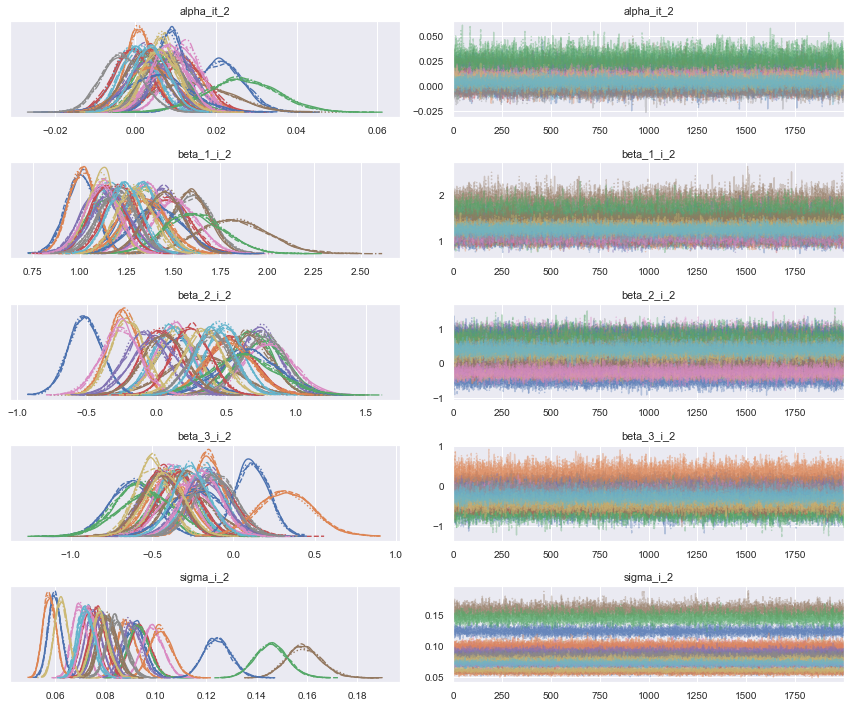

In [74]:
az.plot_trace(traces_hierarchical_2, var_names=["alpha_it_2", "beta_1_i_2",  "beta_2_i_2", "beta_3_i_2","sigma_i_2",]) 
plt.tight_layout()

## 2.4. Return Prediction


In [75]:
# Predict with history market data
predicted_his_return = ff_data[ff_data.columns[0:4]]

for ticker in tickers:
  predicted_his_return[ticker] = ff_data["RF"] + betas_hierarchical_2.T[ticker]['alpha_it_mean'] + \
    betas_hierarchical_2.T[ticker]['beta_1_mean'] * ff_data["Mkt_RF"] + betas_hierarchical_2.T[ticker]['beta_2_mean'] * \
      ff_data["SMB"] + betas_hierarchical_2.T[ticker]['beta_3_mean'] * ff_data["HML"] + betas_hierarchical_2.T[ticker]['sigma_mean']

predicted_his_return

/var/folders/g1/974pr2gx7rggmtdylp159jrw0000gn/T/ipykernel_34482/3148953990.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_his_return[ticker] = ff_data["RF"] + betas_hierarchical_2.T[ticker]['alpha_it_mean'] + \
/var/folders/g1/974pr2gx7rggmtdylp159jrw0000gn/T/ipykernel_34482/3148953990.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_his_return[ticker] = ff_data["RF"] + betas_hierarchical_2.T[ticker]['alpha_it_mean'] + \
/var/folders/g1/974pr2gx7rggmtdylp159jrw0000gn/T/ipykernel

,Mkt_RF,SMB,HML,RF,AAPL,ADBE,ADI,ADSK,AMAT,AMD,...,MU,NOV,NVDA,ORCL,QCOM,SAP,SNPS,SONY,TSM,TXN
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-29,0.0245,0.2142,-0.0970,0.0043,0.242439,0.288688,0.300897,0.272091,0.288853,0.318462,...,0.331989,0.222574,0.400938,0.205162,0.142270,0.178273,0.077007,0.212620,0.231647,0.225698
2000-03-31,0.0520,-0.1723,0.0817,0.0047,0.108943,0.047896,0.010361,0.084826,0.019030,0.191772,...,0.076054,0.117944,0.109942,0.063489,0.146260,0.117577,0.172903,0.068078,0.063472,0.052240
2000-04-30,-0.0640,-0.0668,0.0726,0.0046,-0.022104,-0.044308,-0.071030,-0.028841,-0.070186,0.017297,...,-0.016362,0.012537,-0.006829,-0.039758,0.011352,-0.040737,0.017890,-0.027506,-0.047589,-0.045300
2000-05-31,-0.0442,-0.0609,0.0481,0.0050,0.020504,-0.005018,-0.030951,0.006913,-0.033288,0.062830,...,0.021336,0.034907,0.042275,-0.004380,0.039333,-0.000402,0.043644,0.002278,-0.009250,-0.011486
2000-06-30,0.0464,0.1285,-0.0843,0.0040,0.250005,0.266402,0.267270,0.256796,0.255327,0.326652,...,0.303106,0.211730,0.375912,0.203383,0.166221,0.199325,0.120766,0.202798,0.225819,0.213475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,-0.0843,0.0209,-0.0597,0.0006,0.042874,0.024857,0.005792,0.000365,-0.020379,0.043542,...,0.037931,-0.016012,0.081677,0.012940,0.007353,-0.010347,-0.005609,-0.002617,0.007500,-0.003319
2022-07-31,0.0957,0.0281,-0.0410,0.0008,0.269453,0.256981,0.246416,0.267358,0.243493,0.368056,...,0.293691,0.237241,0.366681,0.212986,0.213649,0.242728,0.190043,0.212708,0.234597,0.218201
2022-08-31,-0.0377,0.0139,0.0031,0.0019,0.065360,0.058216,0.042006,0.058843,0.034512,0.108899,...,0.086859,0.064782,0.120208,0.038176,0.051263,0.030095,0.037289,0.042794,0.039969,0.036441


The following plots show the comparison between `actual stock returns (grey line)` and `predicted stock returns (pink line)` for each company.

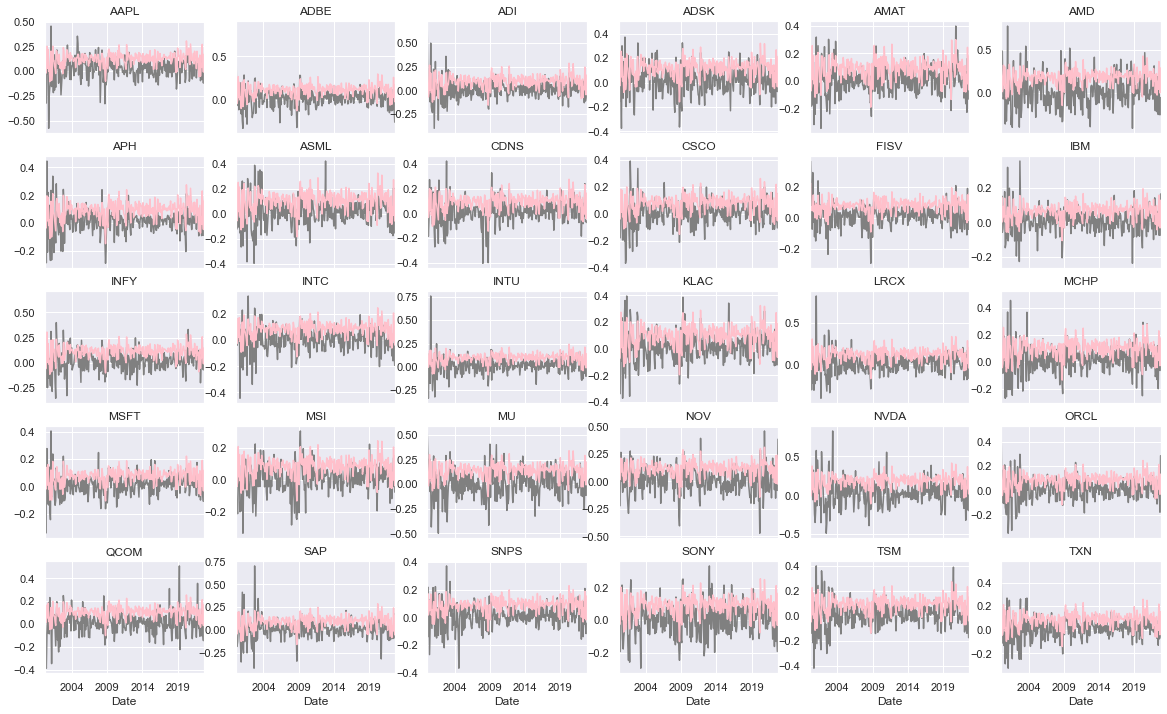

In [76]:
fig, axs = plt.subplots(5,6,figsize = (20,12),sharex=True)
for ticker, ax in zip(tickers, axs.ravel()):
    ff_data[ticker].plot(ax=ax, color='grey')
    predicted_his_return[ticker].plot(ax=ax, color='pink')
    ax.set_title(ticker.upper())
plt.show()

# 3. Portfolio Optimization
In this section, we select 3 stocks with the highest predicted returns to form a portfolio. We use Monte Carlo simulation to see what weighting of stocks gives the best return. We further calculate how much portfolio return buying stocks with such weighting will give in the next period.

## 3.1. Stock Selection

First, we extract the second latest predicted return and select 3 stocks with highest returns, i.e. `AMD`, `NVDA`, and `NOV`.

In [77]:
# Predict with the second latest market data
predicted_latest_return = {}

for ticker in tickers:
  predicted_latest_return[ticker] = ff_data["RF"][-1] + betas_hierarchical_2.T[ticker]['alpha_it_mean'] + betas_hierarchical_2.T[ticker]['beta_1_mean'] * ff_data["Mkt_RF"][-1] + betas_hierarchical_2.T[ticker]['beta_2_mean'] * ff_data["SMB"][-1] + betas_hierarchical_2.T[ticker]['beta_3_mean'] * ff_data["HML"][-1] + betas_hierarchical_2.T[ticker]['sigma_mean']

predicted_latest_return = pd.DataFrame.from_dict(predicted_latest_return, orient='index', columns={"predicted_return"})

top3 = predicted_latest_return.sort_values(by=['predicted_return'],ascending=False).head(3)
top3

,predicted_return
AMD,0.293398
NVDA,0.258248
NOV,0.240163


## 3.2. Monte Carlo Simulation

In this part, we solve the portfolio optimization problem by using Monte Carlo Simulation. The Monte Carlo Simulation is a stochastic (random sampling of inputs) method to solve a statistical problem. Here it assigns random values to the weights and computes the corresponding returns and volatilities. We repeat the random sampling 10,000 times and find the optimal weights among them.


### Returns and Volatilities of Individual Stock
We calculate the average monthly returns and monthly volatilities of each stock in our portfolio.

In [78]:
# Extract daily returns of the three stocks from 2000-02-01 to 2022-10-31
daily_return = stock_data['Adj Close'].pct_change()[20:-21][['AMD','NVDA','NOV']]

# Calculate the average monthly returns
ind_avg_return = stock_returns[0:-1][top3.index.tolist()].mean()
# Calculate the monthly volatilities using daily returns from 2000-02-01 to 2022-10-31
ind_mon_sd = daily_return.std().apply(lambda x: x*np.sqrt(21))

top3_rv = pd.concat([ind_avg_return, ind_mon_sd], axis=1)
top3_rv.columns = ["Return", "Volatility"]
# Returns and Volatilities of the top 3 stocks
top3_rv

,Return,Volatility
AMD,0.021849,0.180855
NVDA,0.033873,0.173431
NOV,0.012105,0.140457


### Portfolio Returns and Volatilities

Here we form 10000 portfolio using Monte Carlo Simulation and calculate the portfolio returns and volatilities.

`Portfolio Return` is the sum of the product of individual stock's return and its weight. In other words, it is the dot product of a matrix of weights and a matrix of individual stock's returns.

`Portfolio Volatility` is calculated differently from the individual stock's volatility. The formula is:
$$\sigma^2(Rp) = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i w_j COV(R_i, R_j) $$
Here, $\sigma^2(Rp)$ denotes the variance of returns of the portfolio. The $w_i$ and $w_j$ denote weights of all stocks from 1 to n (in our case from 1 to 3) and $COV(R_i, R_j)$ is the covariance of the two stocks denoted by $_i$ and $_j$. In other words, we multiply the weight matrix horizontally and vertically with the covariance matrix.

The methodology revolves around the concept that as we increase the number of portfolios simulated, we will get closer to the actual optimum portfolio. For comparison, a portfolio that weights are equally allocated is added in the final row of the dataframe.

In [79]:
port_ret = []
port_vol = []
port_weights = []

# The number of weights we will randomly created, also the number of portfolios will be simulated
num_portfolios = 10000 
num_stocks = 3

In [80]:
# Obtain the covariance matrix of the daily returns of the 3 stocks
cov_matrix = daily_return.cov()
cov_matrix

,AMD,NVDA,NOV
AMD,0.001558,0.000727,0.000295
NVDA,0.000727,0.001432,0.000325
NOV,0.000295,0.000325,0.000939


In [81]:
for portfolio in range(num_portfolios):
    weights = np.random.random(num_stocks) # Create weights randomly
    weights = weights/np.sum(weights) # Make the sum of weights equals 1
    port_weights.append(weights)
    returns = np.dot(weights, ind_avg_return) # Compute the portfolio return
    port_ret.append(returns)
    
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum() # Compute portfolio variance
    sd = np.sqrt(var*21) # Compute monthly volatility
    port_vol.append(sd) # Append volatility in the array

In [82]:
# Create a equally weighted portfolio and add it at the end of all lists
equal_weight = np.linspace(0,0,3) + 1/3
equal_weight = equal_weight.tolist()
port_weights.append(equal_weight)
port_ret.append(np.dot(equal_weight, ind_avg_return))
port_vol.append(np.sqrt(21*cov_matrix.mul(equal_weight, axis=0).mul(equal_weight, axis=1).sum().sum()))

In [83]:
# Merge the lists of weights, returns and volatilities into one Dataframe
data = {'Return':port_ret, 'Volatility':port_vol}

for counter, symbol in enumerate(top3.index.tolist()):
    data[symbol+' weight'] = [w[counter] for w in port_weights]

portfolios  = pd.DataFrame(data)
portfolios.tail() # Dataframe of the 10001 portfolios created

,Return,Volatility,AMD weight,NVDA weight,NOV weight
9996,0.022786,0.123609,0.296350,0.358031,0.345618
9997,0.018141,0.126863,0.499434,0.053727,0.446838
9998,0.026701,0.141019,0.392270,0.494918,0.112813
9999,0.023519,0.133096,0.465003,0.316173,0.218824
10000,0.022609,0.124301,0.333333,0.333333,0.333333


## 3.3. The Optimal Portfolio
For the portfolios we simulated, we plot their returns and volatilities to find `the Efficient Frontier`. The Efficient Frontier is the left edge of the scatter plot with 'return' on the Y-axis and 'volatility' on the X-axis. It shows the portfolios that offer the highest return at a given risk level.

We find the optimal portfolio based on `Sharpe Ratio`. The ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk. The formula for this ratio is:
$$Sharpe\ Ratio = \frac{R_p - R_f}{\sigma_p}$$

For comparison, we also plot the portfolio that offers the lowest risk and the equal weighted portfolio.

In [84]:
# Find the optimal portfolio
rf = ff_data['RF'][-1] # risk-free return of the second latest period
optimal_port = portfolios.iloc[((portfolios['Return']-rf)/portfolios['Volatility']).idxmax()]
optimal_port

Return         0.030516
Volatility     0.153191
AMD weight     0.106424
NVDA weight    0.798123
NOV weight     0.095453
Name: 6891, dtype: float64

> The optimal portfolio, where the weights of AMD, NVDA, and NOV are 10.64%, 79.81% and 9.55% respectively, offers an average history monthly return of 0.03 and has a history monthly volatility of 0.15.

In [85]:
# Find the portfolio with minimum volatility
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]                           
min_vol_port

Return         0.019133
Volatility     0.117930
AMD weight     0.210941
NVDA weight    0.228443
NOV weight     0.560616
Name: 4968, dtype: float64

> The minimum volatility is in a portfolio where the weights of AMD, NVDA, NOV are 21.09%, 22.84%, and 56.06% respectively. And it offers an average history monthly return of 0.02 and has a history monthly volatility of 0.12.

In [86]:
# Finding the equal weighted portfolio
equal_weight_port = portfolios.iloc[-1]
equal_weight_port

Return         0.022609
Volatility     0.124301
AMD weight     0.333333
NVDA weight    0.333333
NOV weight     0.333333
Name: 10000, dtype: float64

> The portfolio where stocks are equally weighted offers an average history monthly return of 0.02 and has a history monthly volatility of 0.12.

### Plot the Efficient Frontier

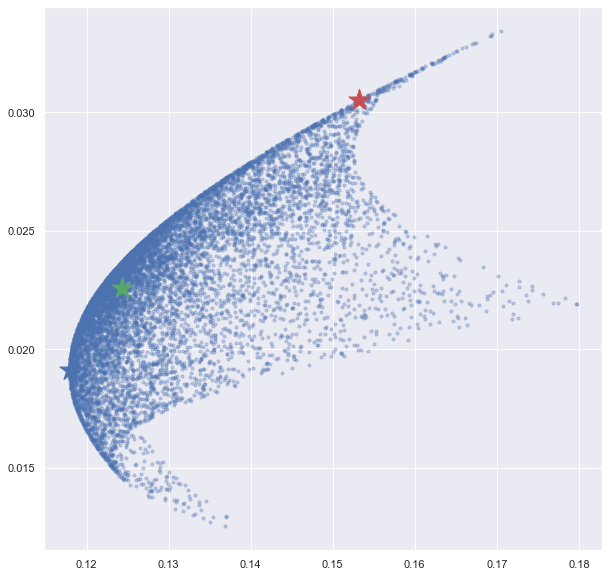

In [87]:
# Plot all simulated portfolios and mark the abovementioned 3 portfolios
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Return'],marker='o', s=10, alpha=0.3)
plt.scatter(optimal_port[1], optimal_port[0], color='r', marker='*', s=500)
plt.scatter(min_vol_port[1], min_vol_port[0], color='b', marker='*', s=500)
plt.scatter(equal_weight_port[1], equal_weight_port[0], color='g', marker='*', s=500)

The red star denotes the **optimal portfolio** that has the highest Sharpe Ratio. The blue star denotes the portfolio with minimum volatility. The green star denotes the portfolio where stocks are equally weighted.
> To have the maximum history return at minimum history risk, we should allocate weights of 10.64%, 79.81% and 9.55% for AMD, NVDA, and, NOV respectively.

### Actual Portfolio Return with the Optimal Weights

In this part, we use the weights of the optimal portfolio multiplied by the actual returns next period (2022-11-30) to obtain the actual portfolio return.

In [88]:
# The latest actual return of top3
top3_latest = stock_returns[top3.index.tolist()].tail(1)
top3_latest

,AMD,NVDA,NOV
Date,,,
2022-11-30,0.292541,0.254155,0.002678


In [89]:
## Portfolio with highest Sharpe Ratio
port_return_optimal = top3_latest[top3_latest.columns[0]]*optimal_port[2] + top3_latest[top3_latest.columns[1]]*optimal_port[3] + top3_latest[top3_latest.columns[2]]*optimal_port[4]
port_return_optimal

Date
2022-11-30    0.234236
Freq: M, dtype: float64

> The actual return of a portfolio with an optimal weights allocation on 2022-11-30 is 0.23.

In [90]:
## Portfolio with lowest risk
port_return_min_vol = top3_latest[top3_latest.columns[0]]*min_vol_port[2] + top3_latest[top3_latest.columns[1]]*min_vol_port[3] + top3_latest[top3_latest.columns[2]]*min_vol_port[4]
port_return_min_vol

Date
2022-11-30    0.12127
Freq: M, dtype: float64

> The actual return of a portfolio with allocation with the lowest risk on 2022-11-30 is 0.12.

In [91]:
## Portfolio with equal weight
port_return_equal_weight = top3_latest[top3_latest.columns[0]]*equal_weight_port[2] + top3_latest[top3_latest.columns[1]]*equal_weight_port[3] + top3_latest[top3_latest.columns[2]]*equal_weight_port[4]
port_return_equal_weight

Date
2022-11-30    0.183125
Freq: M, dtype: float64

> The actual return of a portfolio with equal weights assigned to each stock on 2022-11-30 is 0.18.